<a href="https://colab.research.google.com/github/gwmack/looker_multi_git_dev/blob/main/%5BMcKesson%5D_Looker_CI_CD_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Section: Goals of the workbook**

This workbook is intended to demonstrate and show how to move user generated contents between Looker instances. We will be using three open source packages:


*   Gazer (gzr) - A ruby package is the foundational part of moving all content
*  lDeploy - A python package most commonly used to move content between instances.
*  lManage - A python package that is primarily used for disaster recovery and copying the setup of instances

All of the examples are illustrative and are reference architecture meant to inform and guide installations and are not assumed to be production quality.




##**Section: Setting up our enviroment**

**Python Setup**







Setting up our enviroment with python3 and ruby which run the necessary libraries for this workshop. The section underneath is setting up the python enviroment on our machine.

In [ ]:
!sudo apt update
!sudo apt install python3 python3-dev python3-venv
!sudo apt-get install wget
!wget https://bootstrap.pypa.io/get-pip.py
!sudo python3 get-pip.py

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 1s (167 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
24 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependenc

**Ruby Set Up**

We are now going to set up our Ruby enviroment which is needed for Gazer, the primary source code for moving content within  Looker

In [ ]:
!curl -sL https://github.com/rbenv/rbenv-installer/raw/main/bin/rbenv-installer | bash -


Installing rbenv with git...
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /root/.rbenv/.git/
Updating origin
remote: Enumerating objects: 3252, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 3252 (delta 224), reused 316 (delta 180), pack-reused 2843
Receiving objects: 100% (3252/3252), 656.40 KiB | 11.13 MiB/s, done.
Resolving deltas: 100% (2012/2012), done.
From https://github.com/rbenv/rbenv
 * [new branch]      master     -> origin/master
 * [ne

In [ ]:
!apt-get install ruby-dev
!sudo apt install libtool libffi-dev ruby ruby-dev make
!sudo apt install libzmq3-dev libczmq-dev
!gem install ffi-rzmq rake
!gem install specific_install
!gem install gazer
!gem specific_install https://github.com/SciRuby/iruby
!iruby register


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-lato libgmp-dev libgmpxx4ldbl libruby3.0 rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 ruby3.0-dev ruby3.0-doc rubygems-integration
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev ri bundler
The following NEW packages will be installed:
  fonts-lato libgmp-dev libgmpxx4ldbl libruby3.0 rake ruby ruby-dev ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 ruby3.0-dev ruby3.0-doc rubygems-integration
0 upgraded, 15 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 58.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-lato all 2.0-2.1 [2,696 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:3 http://archive.ubunt

Going to double check that we are in the correct working directory. Colab defaults to our the content folder.

In [ ]:
!pwd
%cd /content
!pwd

/content
/content
/content


## **Section: Setting up the Local Enviroment for Content Movements**

Make a directory that is going to be used for this workshop and furture content migrations. I'm naming this one content_migrations. You should see the folder in left hand side of colab notebook with files section. Although you might need to comment this out if the directory is already present.
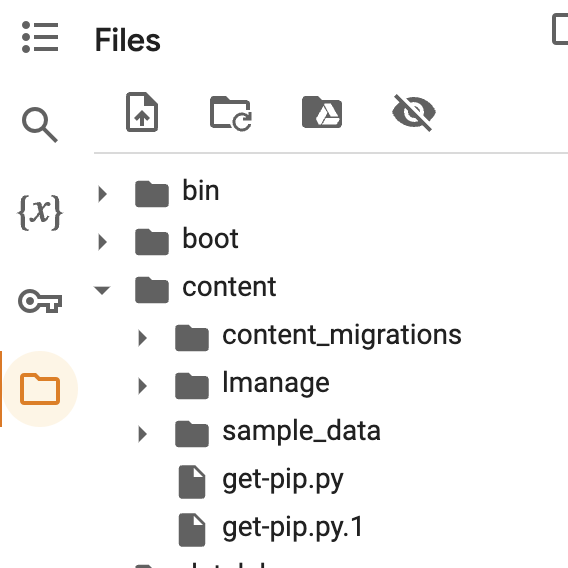


In [ ]:
!mkdir content_migrations

Going to change my directory to content_migrations. Note that to use the cd command in Colab, we need to use the % symbol

In [ ]:
%cd content_migrations/

/content/content_migrations/content_migrations


In [ ]:
!pwd

/content/content_migrations/content_migrations


In [ ]:
!python3 -m venv lmanage_env
!source lmanage_env/bin/activate

We are now going to install the packages needed to migrate content between the two instances

In [ ]:
!pip install google-cloud-storage --quiet
!pip install looker-sdk --quiet
!pip install lmanage --quiet
!pip install looker-deployer --quiet
print("done installing package")


done installing package


This process makes use of the Looker SDK to communicate with your Looker instances. A looker.ini file is required to provide authentication. By default the tool looks for this file in your working directory but if it is named differently or in a different location you can make use of the --ini argument to specify its location. Here's an example ini file:

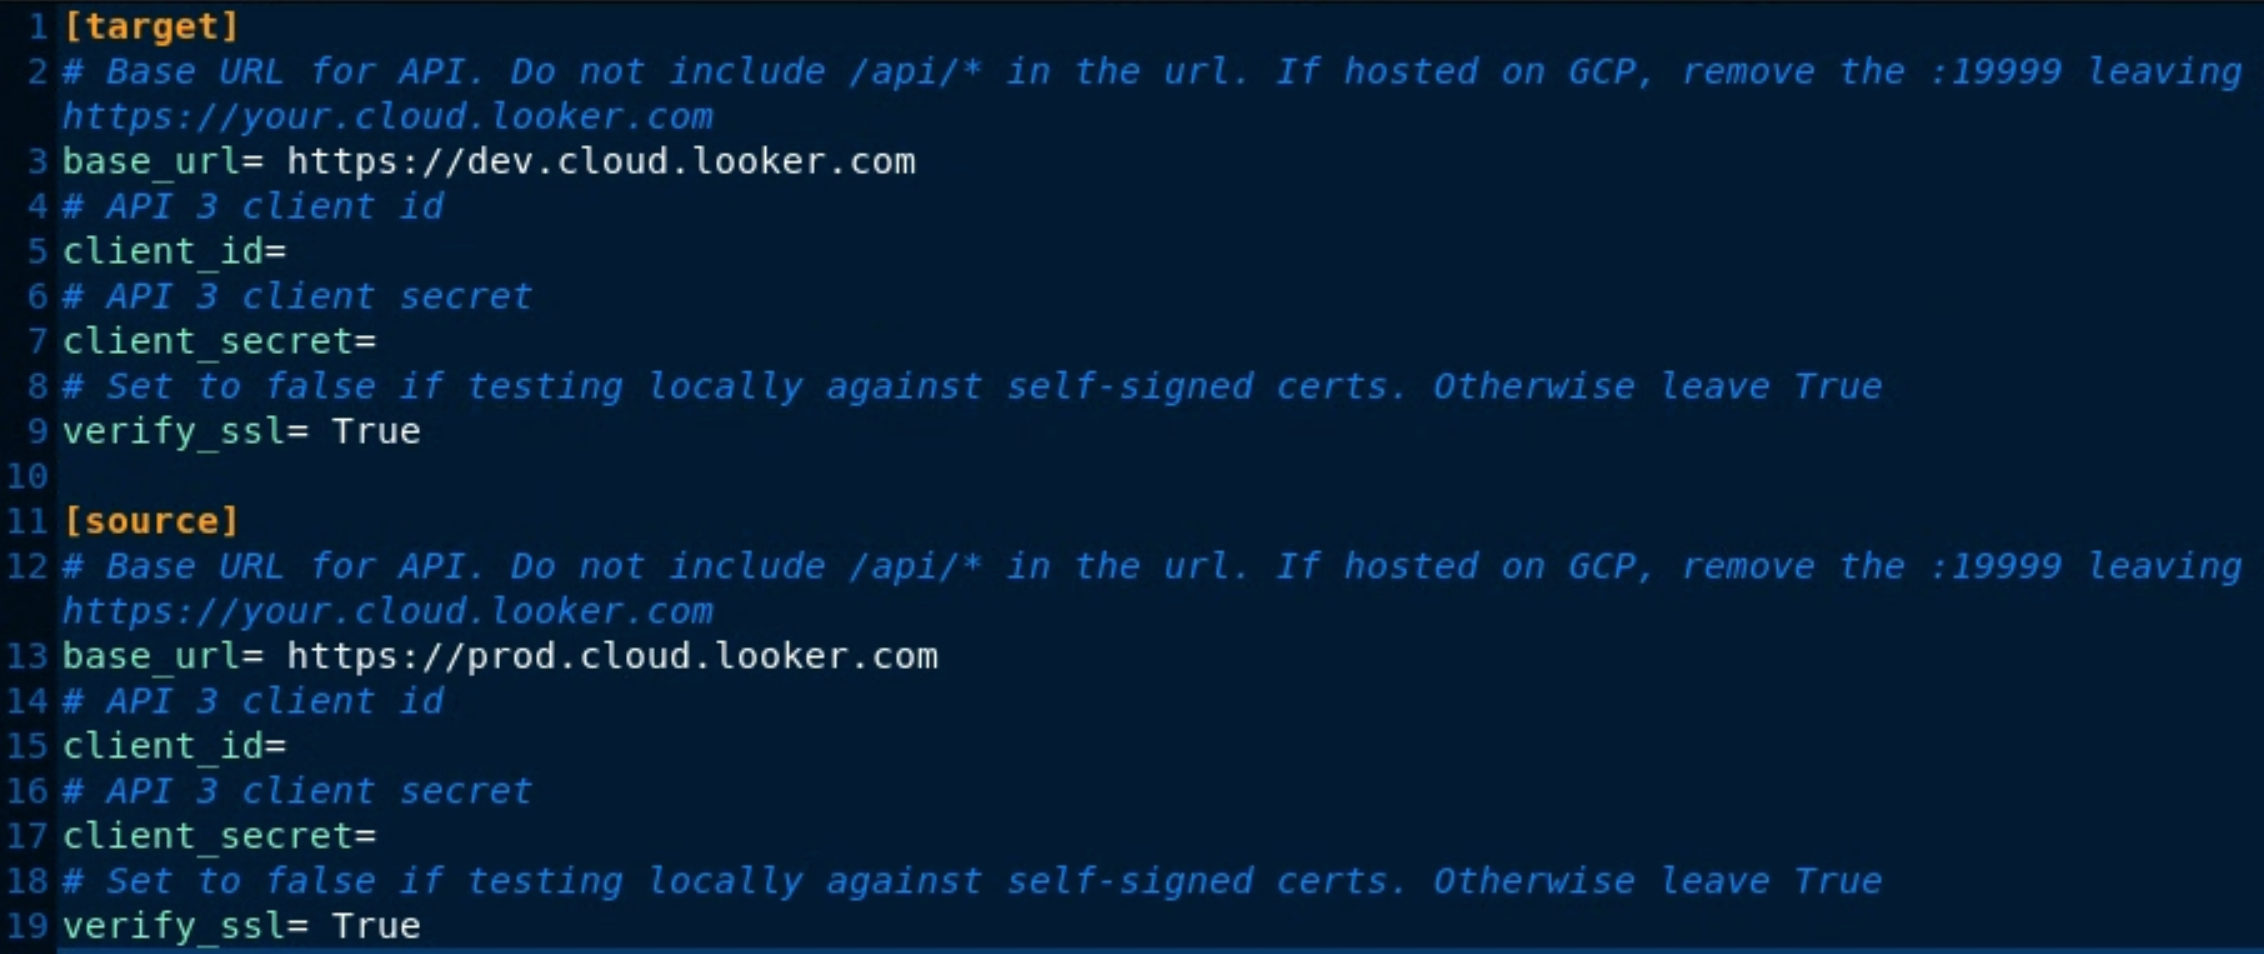

We are now going to intialize our two looker SDK APIs (source, target).



In [ ]:
import looker_sdk
import yaml
import looker_deployer
import lmanage
import os
import logging
from looker_deployer.utils import deploy_logging

logger = deploy_logging.get_logger(__name__)

sdk_source = looker_sdk.init40(config_file="looker.ini",section="source")
sdk_target = looker_sdk.init40(config_file="looker.ini",section="target")


SDKError: Missing required configuration value: base_url

# **Section: Moving Selected User Generated Content with lDeploy**




Using lDeploy to move user generated content follows this path:

Content Identified -> Export Folder with Content to Local Machine -> Source Folder Identified -> Content Imported to Higher Env

A local machine will have to have access to both instances

Using lDeploy as the primary mechanism to move user generated content between the instances will require to initialize the commands with !ldeploy [type of move] [arguments]

In [ ]:
!ldeploy --help


To help with all of these content migrations, we will need to manipulate a lot of folder structures, so we are going to cerate two functions to help define folder structures and paths.

In [ ]:
def recurse_folders(folder_id, folder_list, sdk, debug=False):
    space = sdk.folder(str(folder_id))
    folder_list.append(space.name)
    logger.debug(
        "recursive folder crawl status",
        extra={"current_id": folder_id, "folder_name": space.name, "current_list": folder_list}
    )
    if space.parent_id:
        logger.debug("going for recursion", extra={"parent_id": space.parent_id})
        recurse_folders(space.parent_id, folder_list, sdk, debug)

    return folder_list

def folder_path(folder_list):
    folder_path = "/".join(reversed(folder_list))
    return folder_path

We are going to move a dashboard that is created in a personal folder to a production folder that is for company wide approved dashboards. In this example, we are moving a dashboard that has an overview of the NYC Citibike network

First we need to find the dashboard ID of the dashboard we would like to move. To do that we will can either:


*   Inspect the URL

> >Dashboard ID is the number after dashboard in the URL (looker_url/dashboards/**4**)

*   Use the search_dashboard api call


> > the search_dashboard call looks for **all user defined** dashboards on an instance. Most users will search by title, user or description. You can use the % as a wildcard, if needed. If multiple search criteria are provided, the call defaults to **and logic** to enable **or logic** , filter_or must be set to *true*
> > https://developers.looker.com/api/explorer/4.0/methods/Dashboard/search_dashboards?sdk=py

>  >1.   Get the title of the dashboard from the user who wants to promote it
>  >2.   Search for that title with the api call wanted_dashboard = sdk.search_dashboards(
    title="citibike%",
    filter_or=true)






In [ ]:
#This is part of identifying the content stage
wanted_dashboard = sdk_source.search_dashboards(title="data history%",
                                                id = "51", folder_id = "254", filter_or=False)

In [ ]:
print(wanted_dashboard)

Create a variable that stores the dashboard id we want to migrate.

In [ ]:
dashboard_id = wanted_dashboard[0]["id"]
#This gives us the id of the specific dashboard we will want to import into the higher env
print(dashboard_id)

# Get the value of the Python variable.
folder_source_id = wanted_dashboard[0]["folder"]["id"]

# Set the environment variable.
os.environ['folder_source'] = folder_source_id
#this is going to give us the id of the folder that we will need to export to our local machine
print(folder_source_id)

#We are going to want to know the folder_path in the future, so creating a variable now for it
source_folder_path = folder_path(recurse_folders(folder_source_id,[],sdk_source))
print(source_folder_path)

*Additional information* Potentially useful information for additional use cases

In [ ]:
#print(wanted_dashboard[0]["title"])
#print(wanted_dashboard[0]["user_id"])
#print(wanted_dashboard[0]["slug"])
#print(wanted_dashboard[0]["content_metadata_id"])
#print(wanted_dashboard[0]["folder"])

When we export, we need to export the entire folder of the dashboard we are promoting is in.

The arguments in the call are:

* --ini: name of the .ini file
* --env: enviroment from the .ini file that we are exporting from
* --folders: folder_id that we identified earlier that is stored as an enivornment variable
* --local-target: the file path where the json dashboards will live


In [ ]:
# Set the a local target variable.
local_target = "./content_movement"

os.environ['local_target'] = local_target
print(local_target)

In [ ]:
!ldeploy content export --env target --ini looker.ini --folders $folder_source  --local-target $local_target


Now we need to identify the folder where this content will be in the higher enviroment. We will be searching by the name of the folder

In [ ]:
target_folder_id = sdk_target.search_folders(name="FromDev%")[0]["id"]
print(target_folder_id)


In [ ]:
target_path = folder_path(recurse_folders(target_folder_id,[],sdk_target))
print(target_path)

# Set the environment variable.
os.environ['target_folder_path'] = target_path
print(target_path)

In [ ]:
#Going to create the dashboard path for the enviroment variable
dashboard_path = local_target + "/" + source_folder_path + "/" +"Dashboard_"+wanted_dashboard[0]["id"]+"_"+ wanted_dashboard[0]["title"] + ".json"
dashboard_path =  dashboard_path


# Set the environment variable.
os.environ['dashboard_to_promote'] = dashboard_path
print(dashboard_path)

%env dashboard_to_promote

We will now import those dashboards or folders from the local machine to higher enviroment


In [ ]:
!ldeploy content import --env target --ini looker.ini --dashboards "$dashboard_to_promote"  --target-folder $target_folder_path

**Congrats! The dashboard has been migrated over**

#**Section: Taking Instance Snapshots for Disaster Recovery**

This section is going to focus on taking snapshots of your instance for recovery or for future consolidation. We will be using lmanage as our primary library (https://github.com/looker-open-source/lmanage).

lmanage creates two YAML files:


*   content.yaml: contains all your dashboards, looks, and boards


> * dashboards
>> * alerts
>> * schedules
> * looks
>> * alerts
>> * schedules


*   settings.yaml: contains all your admin configurations
>* Folders and Folder View/Edit Permissions
>* User Attributes
>*User Roles (model and permission sets)
>*User Groups




In [ ]:
#Change to the directory that contains your looker.ini file
#note: you may have to create a new .ini file with only one instance vs having two in previous examples
%cd content_migrations

/content/content_migrations


Confirming we have the appropriate packages imported

In [ ]:
import looker_sdk
from looker_sdk.sdk.api40 import models as models40
import yaml
import looker_deployer
import lmanage
import os
import logging
from looker_deployer.utils import deploy_logging

Now we are going to run the capturator to get our two files. The flags we need to set are


*   -i,--ini-file: name of your .ini file that contains the instance you want the snapshots of
*   -cd: the directory where the two yaml files will be created
* --verbose: sets the logger to more verbose, defaults to false
* --force: skips the confirmation step. If using a notebook, we need to have this as the notebook can't read the confirmation from the shell. If using in a script, would omit and have the confirmation steps



In [ ]:
%%shell
lmanage capturator --ini-file looker.ini -cd ./content_migrations --verbose --force

. INFO     . - lmanage.cli - log_args - INFO - You have set looker.ini for your ini_file   ]8;id=326715;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli.py\cli.py]8;;\:]8;id=116012;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli.py#40\40]8;;\
           variable                                                                                 
  INFO     . - lmanage.cli - log_args - INFO - You have set ./content_migrations for your  ]8;id=605108;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli.py\cli.py]8;;\:]8;id=962667;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli.py#40\40]8;;\
           config_dir variable                                                                      
  INFO     . - lmanage.cli - log_args - INFO - You have set True for your verbose variable ]8;id=837784;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli.py\cli.py]8;;\:]8;id=590664;file:///usr/local/lib/python3.10/dist-packages/lmanage/cli

In [ ]:
#we will now see the two yaml files in our directory
!ls

content_migrations  file.log  lmanage_env  logs  looker.ini
